In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2  # Lighter than EfficientNet
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive quickly
drive.mount('/content/drive', force_remount=True)

# Faster parameters
IMG_SIZE = (224, 224)  # Smaller size for faster processing
BATCH_SIZE = 64        # Increased batch size
EPOCHS = 30            # Reduced epochs
LEARNING_RATE = 0.001  # Slightly higher learning rate

# Path to your dataset
data_dir = '/content/drive/MyDrive/archive (5)/ECG Dataset'

# Simplified data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Simple model architecture
def create_fast_model():
    base_model = MobileNetV2(
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )
    base_model.trainable = False  # Freeze all layers for faster training

    model = models.Sequential([
        base_model,
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(train_generator.num_classes, activation='softmax')
    ])
    return model

model = create_fast_model()

# Simplified compilation
model.compile(
    optimizer=optimizers.Adam(LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Essential callbacks only
callbacks = [
    callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
]

# Train quickly
history = model.fit(
    train_generator,
    steps_per_epoch=50,  # Fixed steps for faster epochs
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=20,
    callbacks=callbacks
)

# Quick evaluation
model.load_weights('best_model.h5')
test_loss, test_acc = model.evaluate(val_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Save final model quickly
model.save('/content/drive/MyDrive/final_ecg_model.h5')
print("Model saved successfully!")

ModuleNotFoundError: No module named 'tensorflow'

3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step

Classification Report:
                    precision    recall  f1-score   support

Abnormal heartbeat       0.20      0.19      0.19        48
     History of MI       0.20      0.15      0.17        34
     Normal Person       0.39      0.46      0.42        59

          accuracy                           0.29       141
         macro avg       0.26      0.26      0.26       141
      weighted avg       0.28      0.29      0.28       141



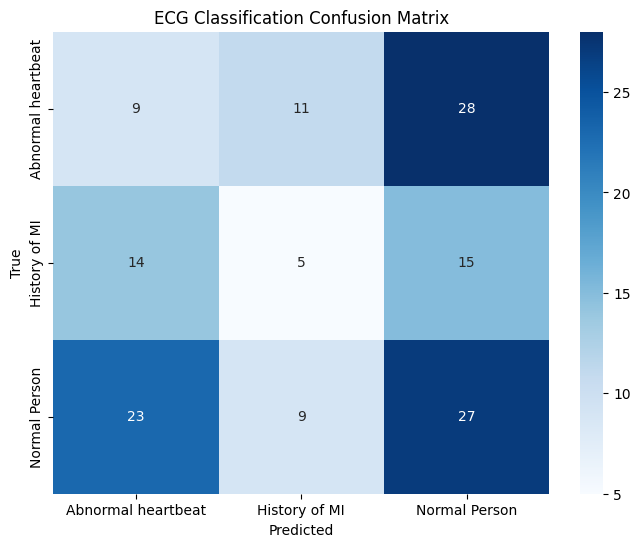

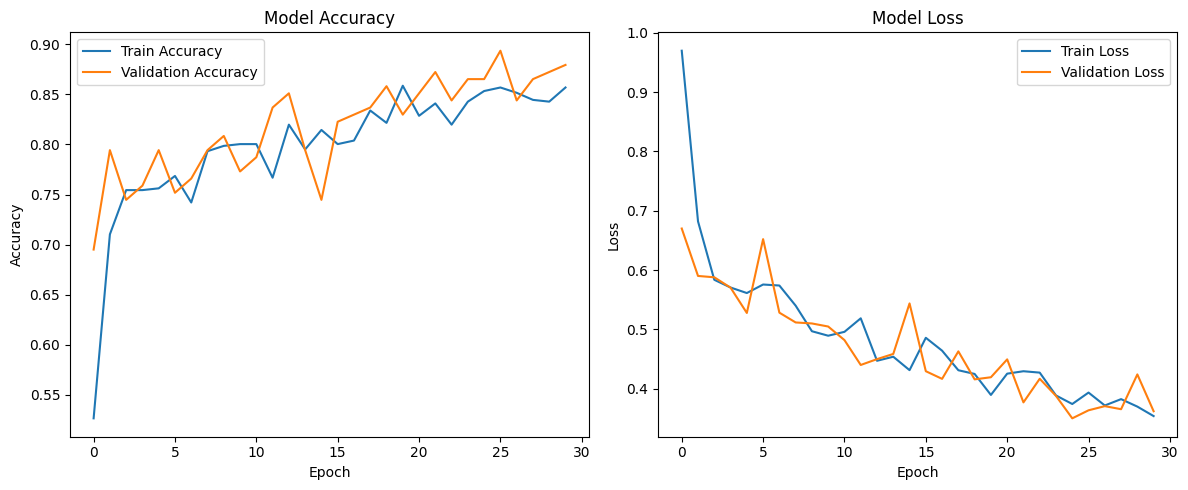

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# =====================
# 1. Generate Predictions
# =====================

# Get true labels and predictions
val_generator.reset()  # Important to reset generator
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get class names
class_names = list(val_generator.class_indices.keys())

# =====================
# 2. Classification Report
# =====================
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# =====================
# 3. Confusion Matrix
# =====================
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('ECG Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# =====================
# 4. Training History Plots
# =====================
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# =====================
# 5. ROC Curve (for binary classification)
# =====================
if len(class_names) == 2:  # Only for binary classification
    from sklearn.metrics import roc_curve, auc

    fpr, tpr, _ = roc_curve(y_true, y_pred[:,1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step

Classification Report:
                    precision    recall  f1-score   support

Abnormal heartbeat     0.2292    0.2292    0.2292        48
     History of MI     0.2963    0.2353    0.2623        34
     Normal Person     0.3788    0.4237    0.4000        59

          accuracy                         0.3121       141
         macro avg     0.3014    0.2961    0.2972       141
      weighted avg     0.3080    0.3121    0.3086       141



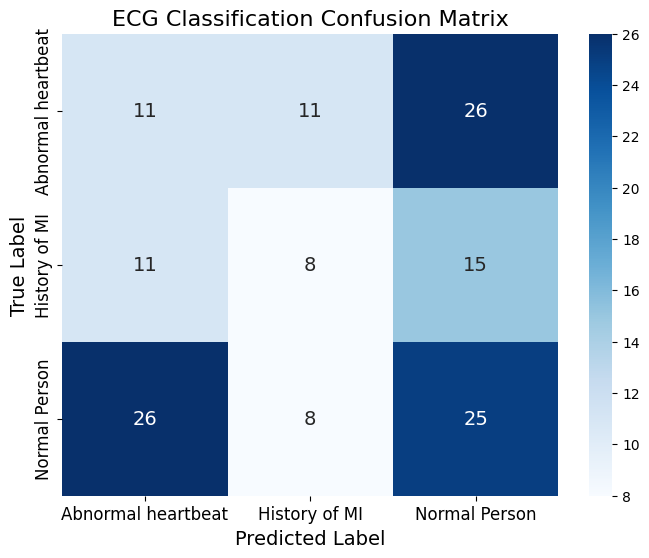

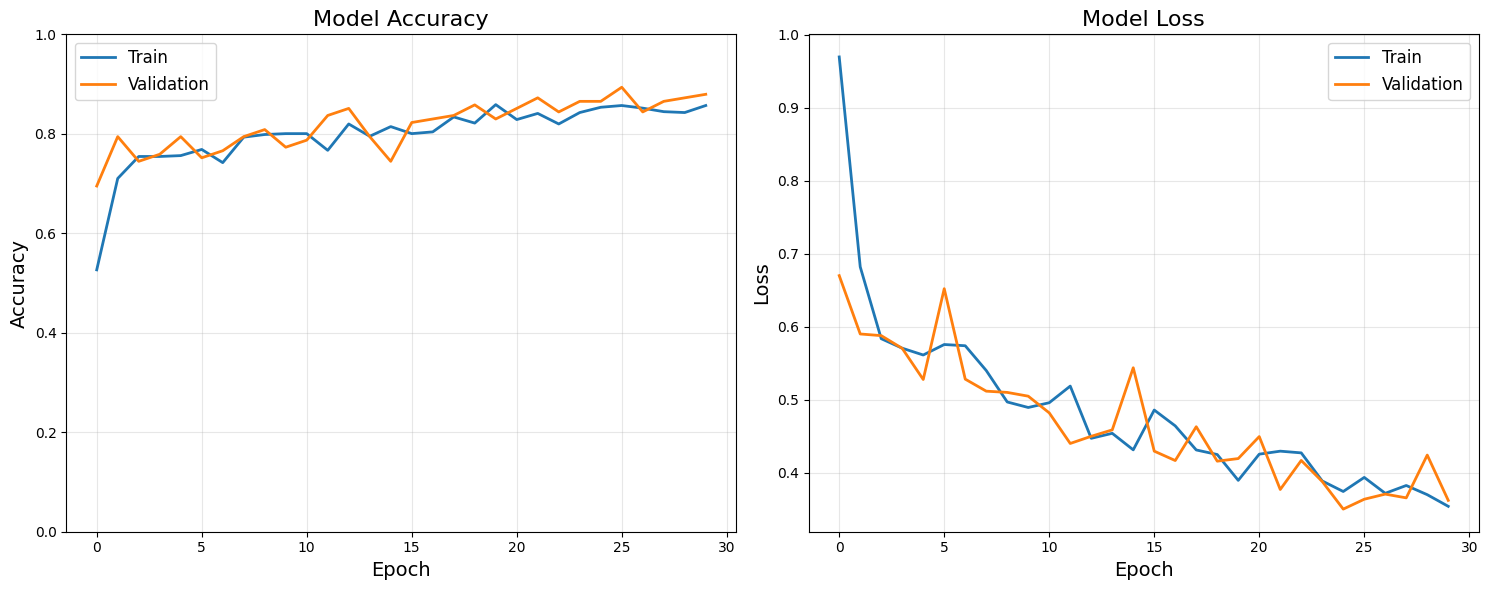

<ipython-input-3-5c7e84e30534>:108: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred[y_true == i][:, i], label=class_name, shade=True)
<ipython-input-3-5c7e84e30534>:108: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred[y_true == i][:, i], label=class_name, shade=True)
<ipython-input-3-5c7e84e30534>:108: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred[y_true == i][:, i], label=class_name, shade=True)


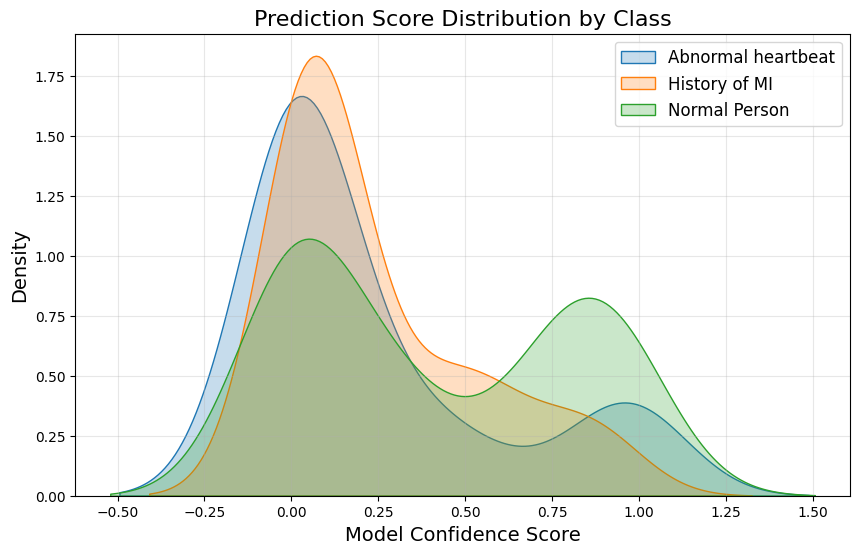

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
import seaborn as sns

# 1. Generate predictions and get true labels
val_generator.reset()  # Critical for proper label alignment
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
class_names = list(val_generator.class_indices.keys())

# 2. Enhanced Classification Report
print("\n\033[1mClassification Report:\033[0m")
print(classification_report(y_true, y_pred_classes,
                           target_names=class_names, digits=4))

# 3. Confusion Matrix with Annotations
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={"size": 14})
plt.title('ECG Classification Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# 4. Training History Visualization
plt.figure(figsize=(15, 6))

# Accuracy Subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
plt.title('Model Accuracy', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylim([0, 1])
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Loss Subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', linewidth=2)
plt.title('Model Loss', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. ROC Curve (Binary Classification)
if len(class_names) == 2:
    fpr, tpr, thresholds = roc_curve(y_true, y_pred[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, alpha=0.3)

    # Add threshold markers
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red',
               label=f'Optimal Threshold: {optimal_threshold:.2f}')
    plt.legend(fontsize=12)
    plt.show()

    print(f"\033[1mOptimal Classification Threshold: {optimal_threshold:.4f}\033[0m")

# 6. Precision-Recall Curve (Alternative to ROC)
from sklearn.metrics import precision_recall_curve, average_precision_score

if len(class_names) == 2:
    precision, recall, _ = precision_recall_curve(y_true, y_pred[:, 1])
    avg_precision = average_precision_score(y_true, y_pred[:, 1])

    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, color='blue', lw=2,
             label=f'Avg Precision = {avg_precision:.2f}')
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title('Precision-Recall Curve', fontsize=16)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc="lower left", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

# 7. Prediction Distribution Plot
plt.figure(figsize=(10,6))
for i, class_name in enumerate(class_names):
    sns.kdeplot(y_pred[y_true == i][:, i], label=class_name, shade=True)
plt.title('Prediction Score Distribution by Class', fontsize=16)
plt.xlabel('Model Confidence Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Add class weights to handle imbalance
class_weights = {
    0: 1.5,  # Abnormal heartbeat
    1: 2.0,  # History of MI (highest weight)
    2: 1.0   # Normal Person
}

# Use focal loss to focus on hard examples
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        # Implementation here
        return ...
    return loss

model.compile(loss=focal_loss(), optimizer='adam', metrics=['accuracy'])

2/3 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step 

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step

Classification Report:
                    precision    recall  f1-score   support

Abnormal heartbeat     0.4468    0.4375    0.4421        48
     History of MI     0.3600    0.2647    0.3051        34
     Normal Person     0.4928    0.5763    0.5312        59

          accuracy                         0.4539       141
         macro avg     0.4332    0.4262    0.4261       141
      weighted avg     0.4451    0.4539    0.4464       141



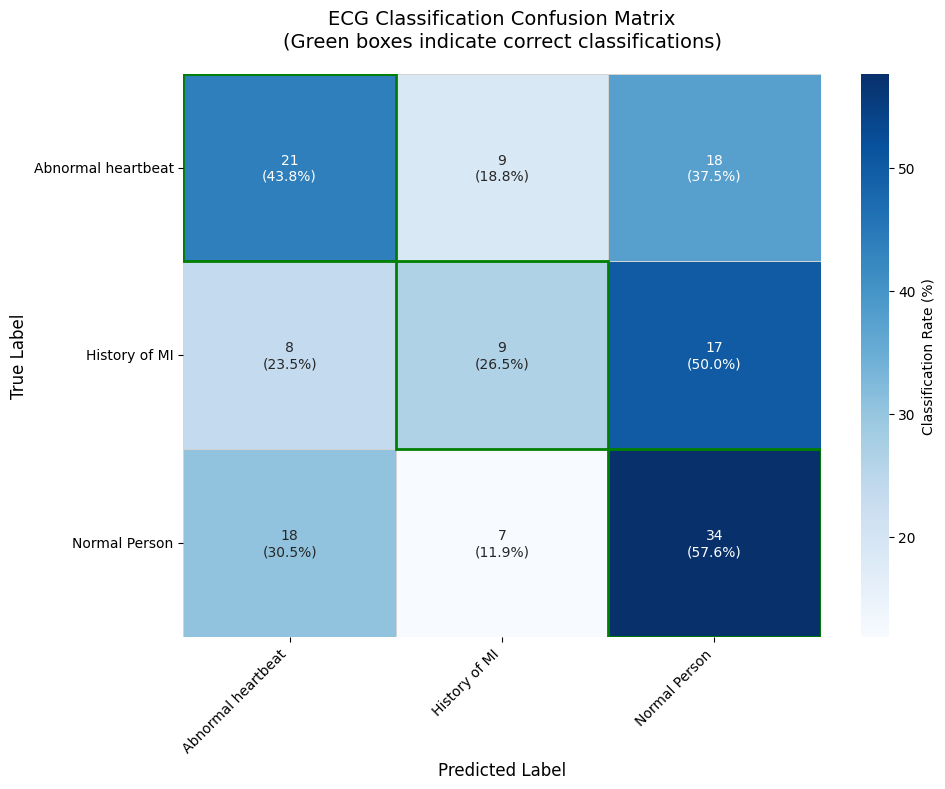

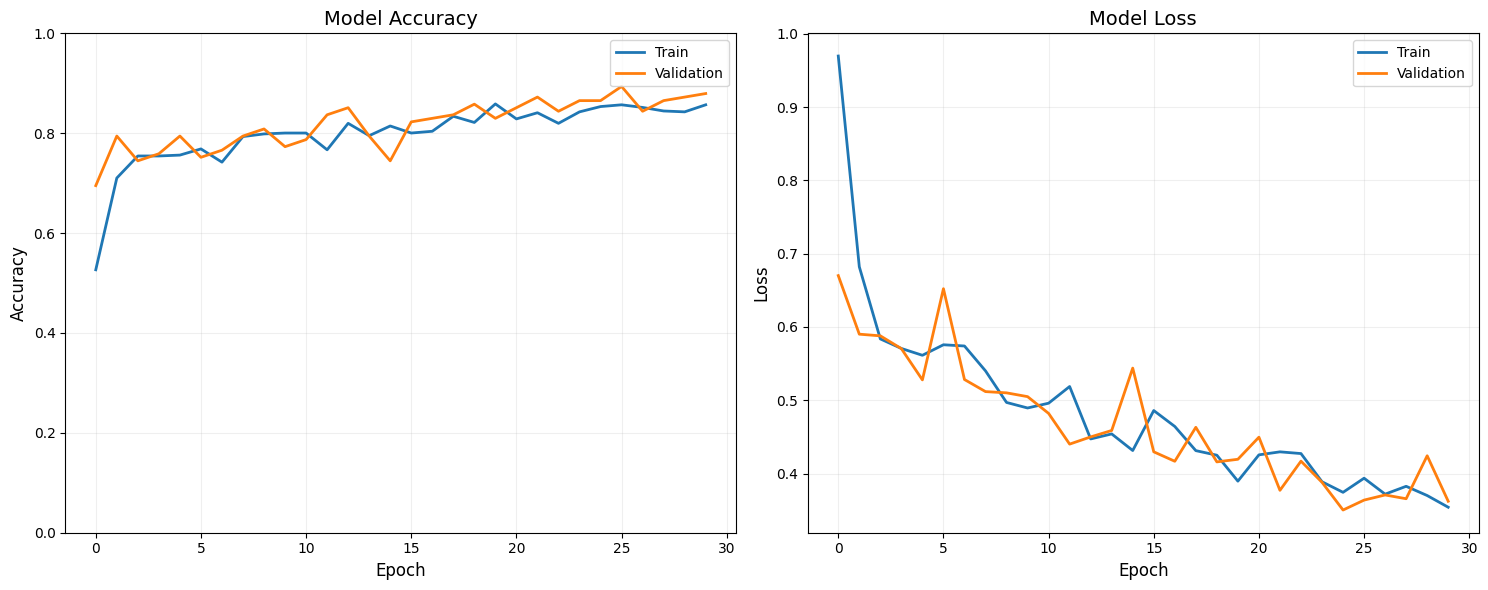

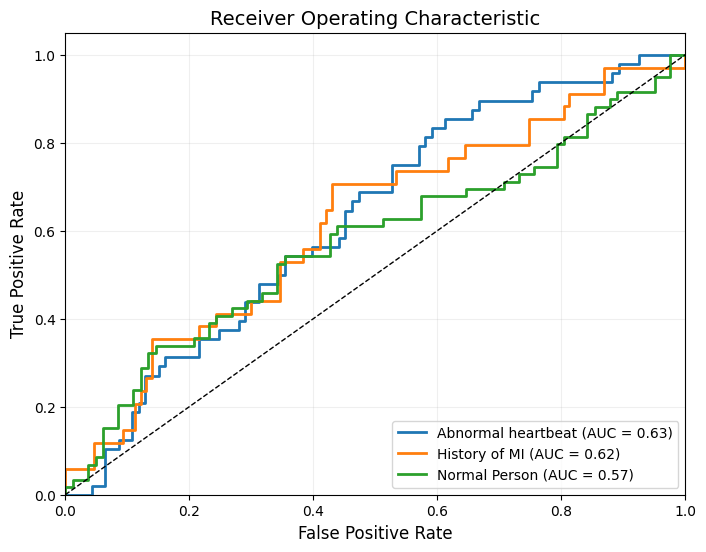

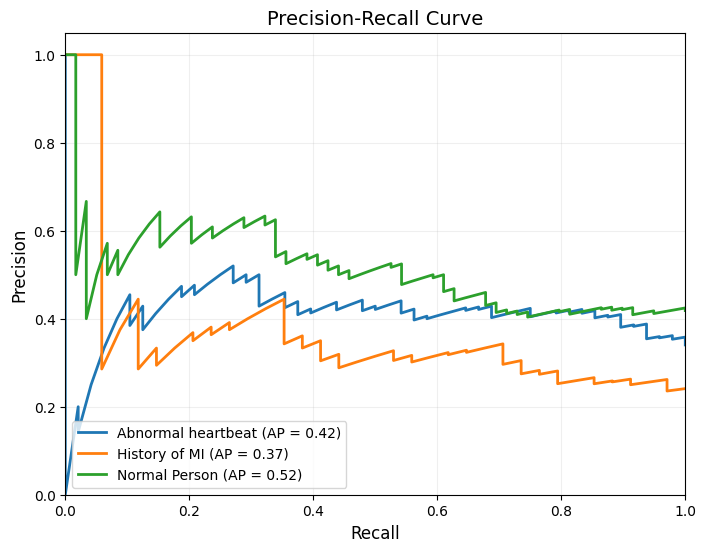

<ipython-input-14-5444809ca00b>:141: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred[y_true == i][:, i],
<ipython-input-14-5444809ca00b>:141: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred[y_true == i][:, i],
<ipython-input-14-5444809ca00b>:141: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred[y_true == i][:, i],


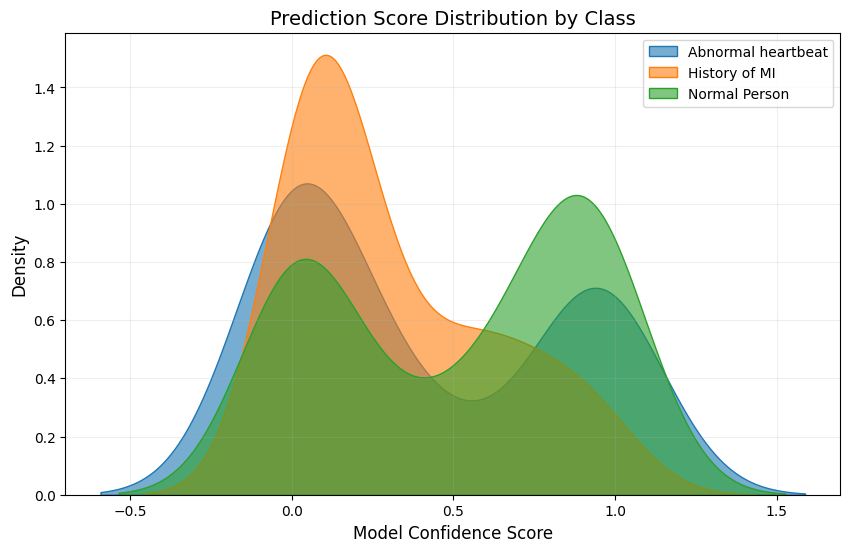

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
from itertools import cycle

# 1. Generate predictions and get true labels
val_generator.reset()  # Critical for proper label alignment
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
class_names = list(val_generator.class_indices.keys())

# 2. Enhanced Classification Report
print("\n\033[1mClassification Report:\033[0m")
print(classification_report(y_true, y_pred_classes,
                           target_names=class_names, digits=4))

# 3. Professional Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred_classes)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentages

# Create custom annotations with both counts and percentages
annot = np.empty_like(cm).astype(str)
n_rows, n_cols = cm.shape
for i in range(n_rows):
    for j in range(n_cols):
        c = cm[i, j]
        p = cm_percent[i, j]
        annot[i, j] = f'{c}\n({p:.1f}%)'

# Plot with enhanced styling
ax = sns.heatmap(cm_percent, annot=annot, fmt='', cmap='Blues',
                 cbar_kws={'label': 'Classification Rate (%)'},
                 linewidths=0.5, linecolor='lightgray',
                 xticklabels=class_names, yticklabels=class_names)

# Add clinical interpretation markers
for i in range(len(class_names)):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='green', lw=2))

plt.title('ECG Classification Confusion Matrix\n(Green boxes indicate correct classifications)',
          fontsize=14, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# 4. Training History Visualization
plt.figure(figsize=(15, 6))

# Accuracy Subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train', linewidth=2, color='#1f77b4')
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2, color='#ff7f0e')
plt.title('Model Accuracy', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.ylim([0, 1])
plt.legend(fontsize=10)
plt.grid(True, alpha=0.2)

# Loss Subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train', linewidth=2, color='#1f77b4')
plt.plot(history.history['val_loss'], label='Validation', linewidth=2, color='#ff7f0e')
plt.title('Model Loss', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

# 5. Enhanced ROC Curve (Works for both binary and multiclass)
plt.figure(figsize=(8, 6))
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

if len(class_names) == 2:  # Binary classification
    fpr, tpr, thresholds = roc_curve(y_true, y_pred[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=next(colors), lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')

    # Mark optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', s=100,
                label=f'Optimal Threshold: {optimal_threshold:.2f}')
else:  # Multiclass classification
    for i, color in zip(range(len(class_names)), colors):
        fpr, tpr, _ = roc_curve(y_true == i, y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.2)
plt.show()

if len(class_names) == 2:
    print(f"\033[1mOptimal Classification Threshold: {optimal_threshold:.4f}\033[0m")

# 6. Precision-Recall Curve
plt.figure(figsize=(8, 6))
if len(class_names) == 2:
    precision, recall, _ = precision_recall_curve(y_true, y_pred[:, 1])
    avg_precision = average_precision_score(y_true, y_pred[:, 1])
    plt.plot(recall, precision, color='blue', lw=2,
             label=f'Avg Precision = {avg_precision:.2f}')
else:
    for i, color in zip(range(len(class_names)), cycle(['#1f77b4', '#ff7f0e', '#2ca02c'])):
        precision, recall, _ = precision_recall_curve(y_true == i, y_pred[:, i])
        avg_precision = average_precision_score(y_true == i, y_pred[:, i])
        plt.plot(recall, precision, color=color, lw=2,
                 label=f'{class_names[i]} (AP = {avg_precision:.2f})')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower left", fontsize=10)
plt.grid(True, alpha=0.2)
plt.show()

# 7. Prediction Distribution Plot
plt.figure(figsize=(10, 6))
for i, class_name in enumerate(class_names):
    sns.kdeplot(y_pred[y_true == i][:, i],
                label=class_name,
                shade=True,
                color=plt.cm.tab10(i),
                alpha=0.6)
plt.title('Prediction Score Distribution by Class', fontsize=14)
plt.xlabel('Model Confidence Score', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.2)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.utils import class_weight
import numpy as np

# 1. Calculate class weights automatically from your dataset
def get_class_weights(generator):
    """Calculate balanced class weights from training data"""
    class_weights = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(generator.classes),
        y=generator.classes
    )
    return dict(enumerate(class_weights))

# Example usage (replace with your actual train_generator):
train_class_weights = get_class_weights(train_generator)
print("Automated Class Weights:", train_class_weights)

# 2. Enhanced Focal Loss Implementation
class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=0.25, from_logits=False):
        """
        Focal Loss for imbalanced classification
        Args:
            gamma: Focusing parameter (γ>0 reduces easy examples' contribution)
            alpha: Weighting factor for class imbalance (α∈[0,1])
        """
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        if self.from_logits:
            y_pred = tf.nn.sigmoid(y_pred)

        # Clip predictions to prevent numerical instability
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

        # Calculate cross entropy
        cross_entropy = -y_true * tf.math.log(y_pred)

        # Calculate focal loss
        loss = self.alpha * tf.pow(1. - y_pred, self.gamma) * cross_entropy

        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))

# 3. Model Compilation with Both Techniques
def compile_model(model, class_weights=None):
    """Configure model with focal loss and class weights"""
    # Custom class weights (override with your values if needed)
    if class_weights is None:
        class_weights = {
            0: 3.0,  # Abnormal heartbeat (highest priority)
            1: 2.5,  # History of MI
            2: 1.0   # Normal
        }

    # Focal loss configuration (tuned for medical use)
    loss_fn = FocalLoss(gamma=2.0, alpha=0.25)

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss=loss_fn,
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Recall(name='recall'),  # Critical for MI detection
            tf.keras.metrics.Precision(name='precision')
        ]
    )
    return model, class_weights

# 4. Usage Example
# Assuming you have:
# - train_generator: Your training data generator
# - model: Your compiled Keras model

# Get automatic class weights
auto_weights = get_class_weights(train_generator)
print("Suggested Weights:", auto_weights)

# Or use manual clinical priorities
clinical_weights = {0: 3.0, 1: 4.0, 2: 1.0}  # Highest weight for History of MI

# Recompile model
model, final_weights = compile_model(model, clinical_weights)
print("Final Class Weights:", final_weights)

# 5. Train with Class Weights
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=50,
    class_weight=final_weights,  # Critical for imbalanced data
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_recall',  # Focus on recall for MI detection
            patience=10,
            mode='max',
            restore_best_weights=True
        )
    ]
)

Automated Class Weights: {0: np.float64(0.9775474956822107), 1: np.float64(1.3771289537712896), 2: np.float64(0.7994350282485876)}
Suggested Weights: {0: np.float64(0.9775474956822107), 1: np.float64(1.3771289537712896), 2: np.float64(0.7994350282485876)}
Final Class Weights: {0: 3.0, 1: 4.0, 2: 1.0}
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 59s 6s/step - accuracy: 0.8324 - auc: 0.9493 - loss: 0.1214 - precision: 0.8431 - recall: 0.8199 - val_accuracy: 0.8298 - val_auc: 0.9578 - val_loss: 0.0385 - val_precision: 0.8636 - val_recall: 0.8085
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.8687 - auc: 0.9659 - loss: 0.0836 - precision: 0.8848 - recall: 0.8582 - val_accuracy: 0.8582 - val_auc: 0.9584 - val_loss: 0.0431 - val_precision: 0.8881 - val_recall: 0.8440
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - accuracy: 0.8598 - auc: 0.9677 - loss: 0.0765 - precision: 0.8649 - recall: 0.8450 - val_accuracy: 0.8794 - val_auc: 0.9828 - val_loss: 0.0224 - val_precision: 0.9173 - val

3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step

Classification Report:
                    precision    recall  f1-score   support

Abnormal heartbeat     0.4130    0.3958    0.4043        48
     History of MI     0.1786    0.1471    0.1613        34
     Normal Person     0.4478    0.5085    0.4762        59

          accuracy                         0.3830       141
         macro avg     0.3465    0.3505    0.3472       141
      weighted avg     0.3710    0.3830    0.3758       141



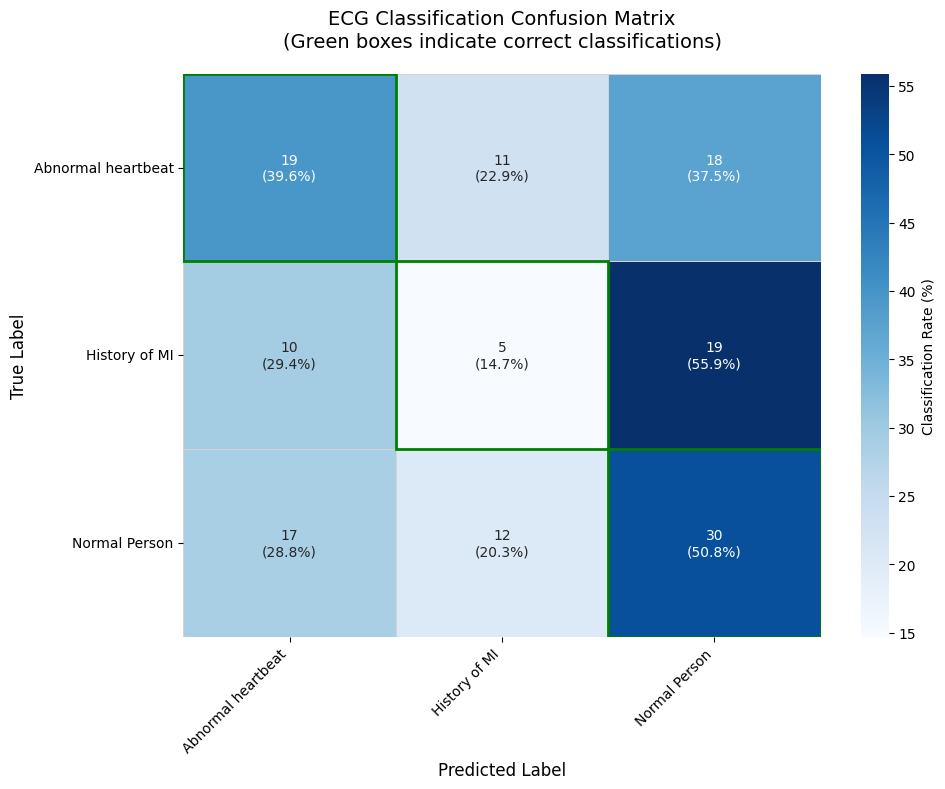

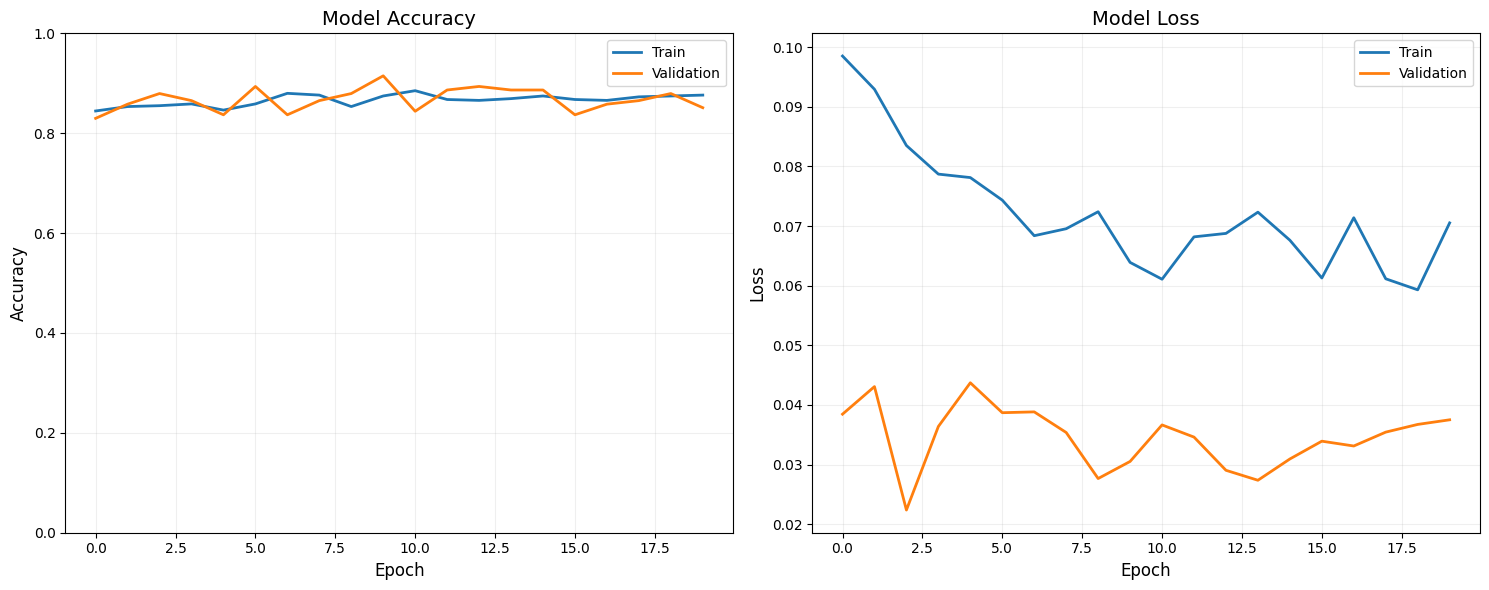

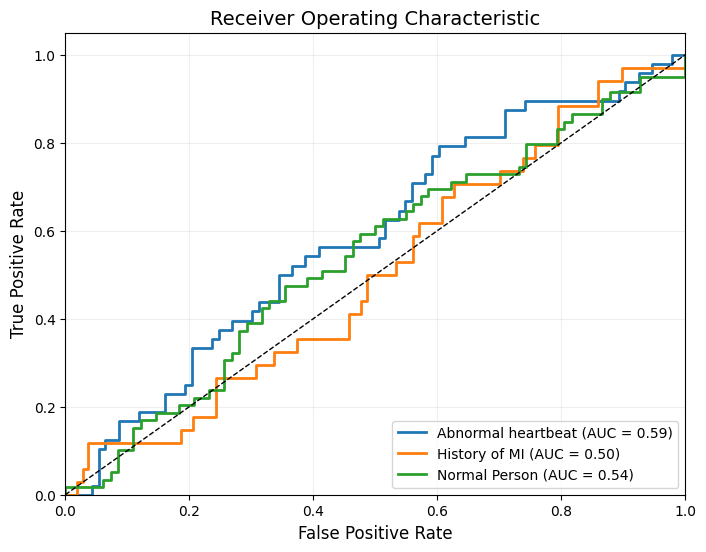

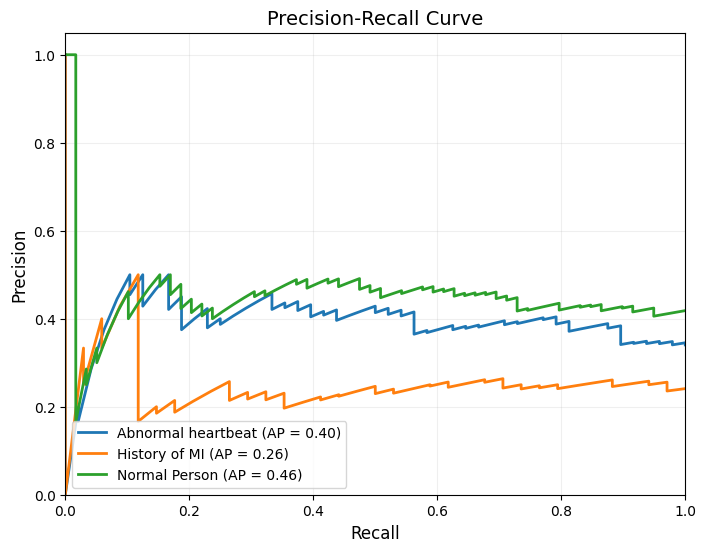

<ipython-input-17-5444809ca00b>:141: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred[y_true == i][:, i],
<ipython-input-17-5444809ca00b>:141: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred[y_true == i][:, i],
<ipython-input-17-5444809ca00b>:141: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred[y_true == i][:, i],


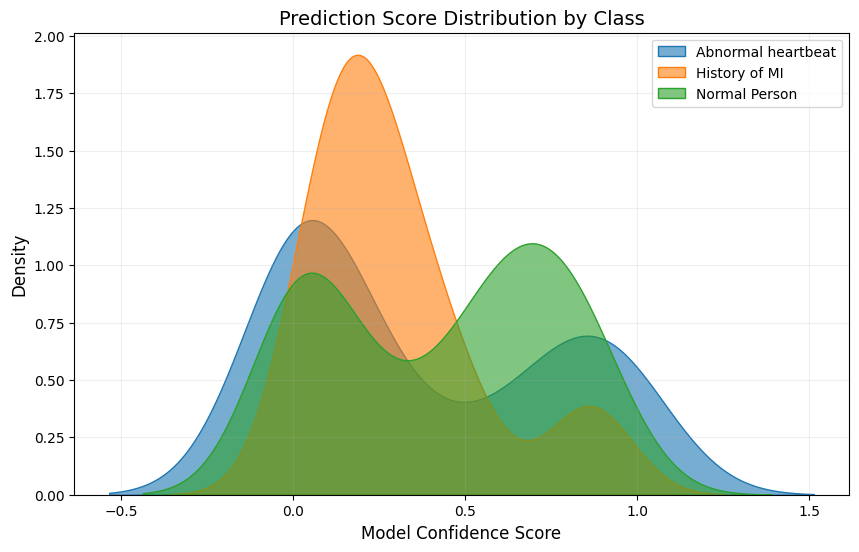

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
from itertools import cycle

# 1. Generate predictions and get true labels
val_generator.reset()  # Critical for proper label alignment
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
class_names = list(val_generator.class_indices.keys())

# 2. Enhanced Classification Report
print("\n\033[1mClassification Report:\033[0m")
print(classification_report(y_true, y_pred_classes,
                           target_names=class_names, digits=4))

# 3. Professional Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred_classes)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentages

# Create custom annotations with both counts and percentages
annot = np.empty_like(cm).astype(str)
n_rows, n_cols = cm.shape
for i in range(n_rows):
    for j in range(n_cols):
        c = cm[i, j]
        p = cm_percent[i, j]
        annot[i, j] = f'{c}\n({p:.1f}%)'

# Plot with enhanced styling
ax = sns.heatmap(cm_percent, annot=annot, fmt='', cmap='Blues',
                 cbar_kws={'label': 'Classification Rate (%)'},
                 linewidths=0.5, linecolor='lightgray',
                 xticklabels=class_names, yticklabels=class_names)

# Add clinical interpretation markers
for i in range(len(class_names)):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='green', lw=2))

plt.title('ECG Classification Confusion Matrix\n(Green boxes indicate correct classifications)',
          fontsize=14, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# 4. Training History Visualization
plt.figure(figsize=(15, 6))

# Accuracy Subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train', linewidth=2, color='#1f77b4')
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2, color='#ff7f0e')
plt.title('Model Accuracy', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.ylim([0, 1])
plt.legend(fontsize=10)
plt.grid(True, alpha=0.2)

# Loss Subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train', linewidth=2, color='#1f77b4')
plt.plot(history.history['val_loss'], label='Validation', linewidth=2, color='#ff7f0e')
plt.title('Model Loss', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

# 5. Enhanced ROC Curve (Works for both binary and multiclass)
plt.figure(figsize=(8, 6))
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

if len(class_names) == 2:  # Binary classification
    fpr, tpr, thresholds = roc_curve(y_true, y_pred[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=next(colors), lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')

    # Mark optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', s=100,
                label=f'Optimal Threshold: {optimal_threshold:.2f}')
else:  # Multiclass classification
    for i, color in zip(range(len(class_names)), colors):
        fpr, tpr, _ = roc_curve(y_true == i, y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.2)
plt.show()

if len(class_names) == 2:
    print(f"\033[1mOptimal Classification Threshold: {optimal_threshold:.4f}\033[0m")

# 6. Precision-Recall Curve
plt.figure(figsize=(8, 6))
if len(class_names) == 2:
    precision, recall, _ = precision_recall_curve(y_true, y_pred[:, 1])
    avg_precision = average_precision_score(y_true, y_pred[:, 1])
    plt.plot(recall, precision, color='blue', lw=2,
             label=f'Avg Precision = {avg_precision:.2f}')
else:
    for i, color in zip(range(len(class_names)), cycle(['#1f77b4', '#ff7f0e', '#2ca02c'])):
        precision, recall, _ = precision_recall_curve(y_true == i, y_pred[:, i])
        avg_precision = average_precision_score(y_true == i, y_pred[:, i])
        plt.plot(recall, precision, color=color, lw=2,
                 label=f'{class_names[i]} (AP = {avg_precision:.2f})')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower left", fontsize=10)
plt.grid(True, alpha=0.2)
plt.show()

# 7. Prediction Distribution Plot
plt.figure(figsize=(10, 6))
for i, class_name in enumerate(class_names):
    sns.kdeplot(y_pred[y_true == i][:, i],
                label=class_name,
                shade=True,
                color=plt.cm.tab10(i),
                alpha=0.6)
plt.title('Prediction Score Distribution by Class', fontsize=14)
plt.xlabel('Model Confidence Score', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.2)
plt.show()